## Hyperparameter optimization using hyperopt

In [1]:
from heartnet_v1 import heartnet
import ast # for list import
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from keras.losses import binary_crossentropy
from keras import backend as K

Using TensorFlow backend.


In [2]:
foldname='fold0_noFIR'

In [3]:
random_seed=1
batch_size=64
fold_dir='/media/taufiq/Data/heart_sound/feature/potes_1DCNN/balancedCV/folds/'
log_dir= '/media/taufiq/Data/heart_sound/Heart_Sound/codes/logs/'
bn_momentum = 0.99
eps= 1.1e-5
bias=False
l2_reg=0.
# l2_reg_dense=0.
kernel_size=5
maxnorm=10000.
dropout_rate=0.5
dropout_rate_dense=0.
padding='valid'
activation_function='relu'
subsam=2
load_path=False
lr=0.0012843784 
lr_decay=0.0001132885
FIR_train=True
num_filt=(8,4)
num_dense=20
params = dict()
print "values initialized"

values initialized


In [4]:
import tables
from heartnet_v1 import reshape_folds
feat = tables.open_file(fold_dir + foldname + '.mat')
x_train = feat.root.trainX[:]
y_train = feat.root.trainY[0, :]
x_val = feat.root.valX[:]
y_val = feat.root.valY[0, :]
train_parts = feat.root.train_parts[:]
val_parts = feat.root.val_parts[0, :]

for i in range(0, y_train.shape[0]):
    if y_train[i] == -1:
        y_train[i] = 0  ## Label 0 for normal 1 for abnormal
for i in range(0, y_val.shape[0]):
    if y_val[i] == -1:
        y_val[i] = 0
x_train, y_train, x_val, y_val = reshape_folds(x_train, x_val, y_train, y_val)
print "loading complete"

(80531, 2500, 1)
(80531, 1)
(7324, 2500, 1)
(7324, 1)
loading complete


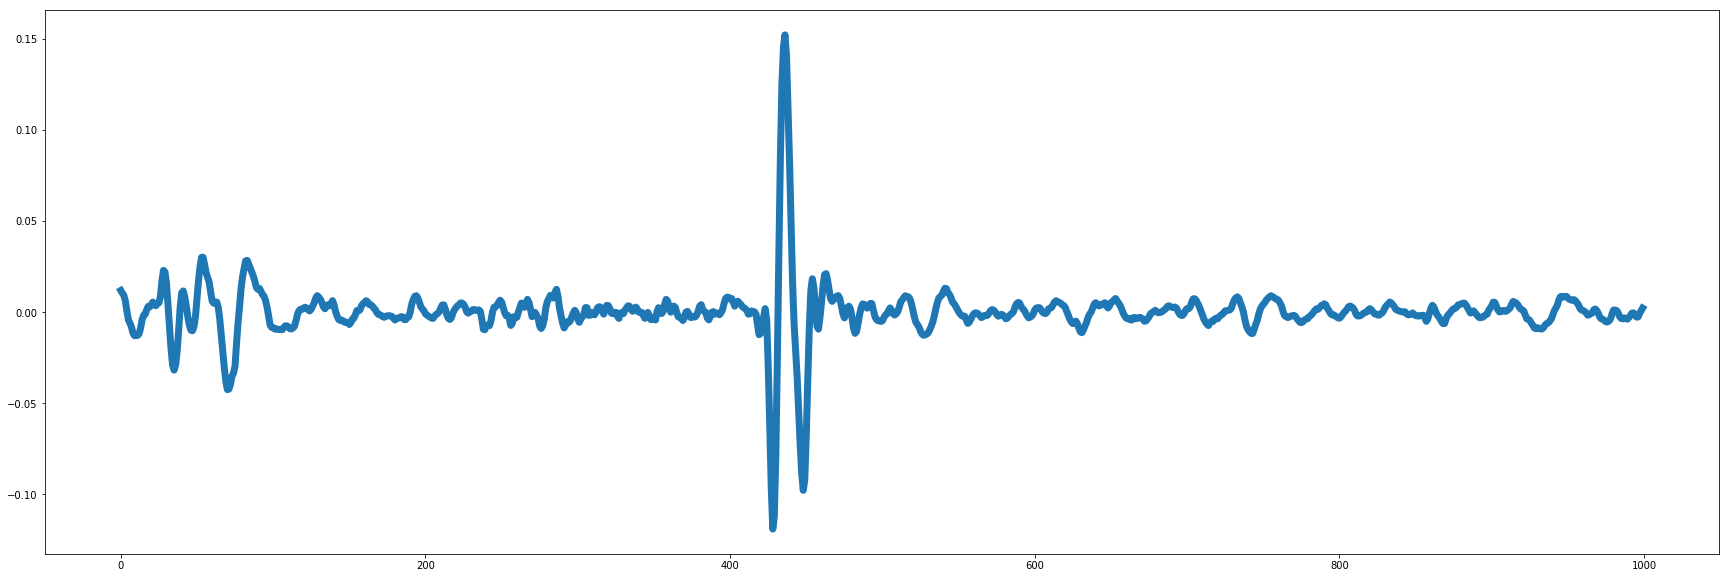

In [16]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize']=(30,10)
plt.plot(x_train[0,:1000],linewidth=7.0)
plt.show()

In [9]:
def objective(args):
    l2_reg_dense = args
    print "args {}".format(args)
    model = heartnet(activation_function, bn_momentum, bias, dropout_rate, dropout_rate_dense,
                 eps, kernel_size, l2_reg, l2_reg_dense, load_path, lr, lr_decay, maxnorm,
                 padding, random_seed, subsam, num_filt, num_dense, FIR_train)
    model.fit(x_train, y_train,
          batch_size=256,
          epochs=20,
          shuffle=True,
          verbose=1,
          initial_epoch=0)
    y_pred = model.predict(x_val)
    loss = K.eval(K.mean(K.variable(K.eval(binary_crossentropy(K.variable(y_val),K.variable(y_pred))))))
    params[str(args)]=loss
    print loss
    return loss    

In [10]:
from hyperopt import hp, Trials, fmin, tpe
trials = Trials()
best = fmin(objective,
    space=hp.uniform('x',0.03,0.1),
    algo=tpe.suggest,
    max_evals=10,
    trials=trials)

args 0.0496942947446
Epoch 1/20
80531/80531 [==============================] - 17s 214us/step - loss: 0.4761 - acc: 0.8314
Epoch 2/20
80531/80531 [==============================] - 17s 206us/step - loss: 0.3703 - acc: 0.8677
Epoch 3/20
80531/80531 [==============================] - 16s 205us/step - loss: 0.3445 - acc: 0.8741
Epoch 4/20
80531/80531 [==============================] - 17s 205us/step - loss: 0.3378 - acc: 0.8797
Epoch 5/20
80531/80531 [==============================] - 17s 205us/step - loss: 0.3369 - acc: 0.8842
Epoch 6/20
80531/80531 [==============================] - 17s 206us/step - loss: 0.3180 - acc: 0.8891
Epoch 7/20
80531/80531 [==============================] - 17s 207us/step - loss: 0.3206 - acc: 0.8877
Epoch 8/20
80531/80531 [==============================] - 17s 206us/step - loss: 0.3120 - acc: 0.8906
Epoch 9/20
80531/80531 [==============================] - 17s 206us/step - loss: 0.3114 - acc: 0.8908
Epoch 10/20
80531/80531 [==============================] - 16

80531/80531 [==============================] - 17s 206us/step - loss: 0.2690 - acc: 0.9032
Epoch 20/20
80531/80531 [==============================] - 17s 206us/step - loss: 0.2699 - acc: 0.9022
0.542161
args 0.0987612037451
Epoch 1/20
80531/80531 [==============================] - 18s 222us/step - loss: 0.5338 - acc: 0.8353
Epoch 2/20
80531/80531 [==============================] - 17s 206us/step - loss: 0.3843 - acc: 0.8693
Epoch 3/20
80531/80531 [==============================] - 17s 205us/step - loss: 0.3794 - acc: 0.8767
Epoch 4/20
80531/80531 [==============================] - 17s 206us/step - loss: 0.3559 - acc: 0.8796
Epoch 5/20
80531/80531 [==============================] - 16s 205us/step - loss: 0.3380 - acc: 0.8836
Epoch 6/20
80531/80531 [==============================] - 17s 205us/step - loss: 0.3289 - acc: 0.8848
Epoch 7/20
80531/80531 [==============================] - 16s 204us/step - loss: 0.3198 - acc: 0.8869
Epoch 8/20
80531/80531 [==============================] - 17s 

80531/80531 [==============================] - 17s 206us/step - loss: 0.2862 - acc: 0.8955
Epoch 18/20
80531/80531 [==============================] - 17s 206us/step - loss: 0.2823 - acc: 0.8957
Epoch 19/20
80531/80531 [==============================] - 17s 206us/step - loss: 0.2824 - acc: 0.8948
Epoch 20/20
80531/80531 [==============================] - 17s 206us/step - loss: 0.2832 - acc: 0.8938
0.548516
args 0.0724329105161
Epoch 1/20
80531/80531 [==============================] - 18s 229us/step - loss: 0.4826 - acc: 0.8403
Epoch 2/20
80531/80531 [==============================] - 17s 206us/step - loss: 0.3763 - acc: 0.8692
Epoch 3/20
80531/80531 [==============================] - 17s 207us/step - loss: 0.3544 - acc: 0.8769
Epoch 4/20
80531/80531 [==============================] - 17s 207us/step - loss: 0.3434 - acc: 0.8814
Epoch 5/20
80531/80531 [==============================] - 17s 208us/step - loss: 0.3313 - acc: 0.8855
Epoch 6/20
80531/80531 [==============================] - 17

In [15]:
best


{'x': 0.04864911065093751}

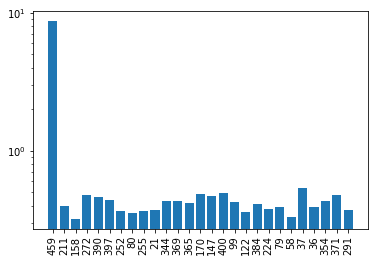

In [90]:
import matplotlib.pyplot as plt

D =(params)

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()),rotation=90)
plt.yscale('log',nonposy='clip')
# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x

plt.show()